### 作業目的: 使用樹型模型進行文章分類

本次作業主利用[Amazon Review data中的All Beauty](https://nijianmo.github.io/amazon/index.html)來進行review評價分類(文章分類)

資料中將review分為1,2,3,4,5分，而在這份作業，我們將評論改分為差評價、普通評價、優良評價(1,2-->1差評、3-->2普通評價、4,5-->3優良評價)

### 載入套件

In [1]:
import json
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

### 資料前處理
文本資料較為龐大，這裡我們取前10000筆資料來進行作業練習

In [2]:
#load json data
N = 10000
all_reviews = []
###<your code>###

count = 0
with open('All_Beauty.json') as file:
    for review in file.readlines():
        if count < N:
            all_reviews.append(json.loads(review))
            count += 1
        else:
            break
            
all_reviews[0]

{'overall': 1.0,
 'verified': True,
 'reviewTime': '02 19, 2015',
 'reviewerID': 'A1V6B6TNIC10QE',
 'asin': '0143026860',
 'reviewerName': 'theodore j bigham',
 'reviewText': 'great',
 'summary': 'One Star',
 'unixReviewTime': 1424304000}

In [3]:
len(all_reviews)

10000

In [4]:
#parse label(overall) and corpus(reviewText)
corpus = []
labels = []

###<your code>###
for review in all_reviews:
    if review.get('overall') == None or review.get('reviewText') == None:
        continue
    else:
        labels.append(review['overall'])
        corpus.append(review['reviewText'])

print(type(labels[0]))
print(type(corpus[0]))
#transform labels: 1,2 --> 1 and 3 --> 2 and 4,5 --> 3

###<your code>###

# for i in range(len(labels)):
#     if labels[i] < 3:
#         labels[i] = 1
#     elif labels[i] == 3:
#         labels[i] = 2
#     else:
#         labels[i] = 3

def mapping(x):
    if x < 3:
        return 1
    elif x == 3:
        return 2
    else:
        return 3

labels = list(map(mapping, labels))

print(len(labels), len(corpus))
print(labels[:10])

<class 'float'>
<class 'str'>
9995 9995
[1, 3, 3, 3, 3, 3, 3, 1, 3, 1]


In [5]:
for text in corpus[:10]:
    print(text)
    print()

great

My  husband wanted to reading about the Negro Baseball and this a great addition to his library
 Our library doesn't haveinformation so this book is his start. Tthank you

This book was very informative, covering all aspects of game.

I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.

This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!

Today I gave a book about the Negro Leagues of Baseball to a traveling friend. Its a book I've read more than once and felt that my friend would truly enjoy. It felt like giving a gift that you wanted to keep for yourself. I parted with the book knowing that my friend would en

In [6]:
#preprocessing data
#remove email address, punctuations, and change line symbol(\n)

###<your code>###
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

def get_word_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_mapping = {'J': wordnet.ADJ,
                   'N': wordnet.NOUN,
                   'V': wordnet.VERB,
                   'R': wordnet.ADV}
    return tag_mapping.get(tag, wordnet.NOUN)

def clean_content(X):
    # remove non-alphabet but ' - , then transfer to lowercase
    X_remove_symbol = [re.sub('[^a-zA-Z\'\-]', ' ', x).lower() for x in X]
    
    # word tokenize
    X_tokenize = [nltk.word_tokenize(x) for x in X_remove_symbol]
    
    # remove stopwords then lemmatize
    stop_words = set(stopwords.words('english'))
    X_lemmatize = []
    for content in X_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_word_pos(word))
                content_clean.append(word)
        X_lemmatize.append(content_clean)
    
    X_output = [' '.join(x) for x in X_lemmatize]
    
    return X_output


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#split corpus and label into train and test
###<your code>###
X = clean_content(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=2)

len(X_train), len(X_test), len(y_train), len(y_test)

(7996, 1999, 7996, 1999)

In [8]:
# 確認總共有幾個字
def how_many_words(X: list) -> int:
    total = set()
    for x in X:
        content = x.split(' ')
        total |= set(content)
    return len(total)

how_many_words(X_train)

7844

In [9]:
#change corpus into vector
#you can use tfidf or BoW here

###<your code>###

cv = CountVectorizer(max_features=2000)

#transform training and testing corpus into vector form
x_train_cv = cv.fit_transform(X_train).toarray()
x_test_cv = cv.transform(X_test).toarray()

# TFIDF

tfidf = TfidfVectorizer(max_features=2000, smooth_idf=True)

#transform training and testing corpus into vector form
x_train_tf = tfidf.fit_transform(X_train).toarray()
x_test_tf = tfidf.transform(X_test).toarray()

In [16]:
# 共現矩陣 --> PPMI --> SVD 降維 --> 計算文本向量
import numpy as np
# 共現矩陣
def create_co_matrix(corpus: list, vocab_list: list, word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(len(word2idx), len(word2idx)), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms_list = sms.split(' ')
        sms_ids = list()
        
        for w in sms_list:
            if w in word2idx:                                 # 將每一筆資料轉成 word index
                sms_ids.append(word2idx[w])                   # 若不在 word index 裡的字都轉成 -1
            else:
                sms_ids.append(-1)
        
        for center_i, center_word_id in enumerate(sms_ids):
            if center_word_id != -1:
                left_center_i = center_i - window_size if center_i-window_size >= 0 else 0
                context_ids = sms_ids[left_center_i:center_i]

                for left_i, left_word_id in enumerate(context_ids):
                    if left_word_id != -1:
                        co_matrix[center_word_id, left_word_id] += 1
                        co_matrix[left_word_id, center_word_id] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                    print(f"finishing {idx+1}/{len(corpus)}")
    print("Done")
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        for i in range(len(word2idx)):
            co_matrix[i, i] = 1
        
    return co_matrix

co_matrix = create_co_matrix(X_train, tfidf.get_feature_names(), tfidf.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/7996
finishing 1001/7996
finishing 1501/7996
finishing 2001/7996
finishing 2501/7996
finishing 3001/7996
finishing 3501/7996
finishing 4001/7996
finishing 4501/7996
finishing 5001/7996
finishing 5501/7996
finishing 6001/7996
finishing 6501/7996
finishing 7001/7996
finishing 7501/7996
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
# PPMI

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    import numpy as np
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j]+eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  


array([[4.154468  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.9564476 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.55104226, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 7.4699054 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 7.141132  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.5200877 ]], dtype=float32)

Number of components = 50 and explained variance = 0.16709251701831818
Number of components = 100 and explained variance = 0.2617502808570862
Number of components = 150 and explained variance = 0.33791667222976685
Number of components = 200 and explained variance = 0.4043768048286438
Number of components = 250 and explained variance = 0.463849276304245
Number of components = 300 and explained variance = 0.5179453492164612
Number of components = 350 and explained variance = 0.5669411420822144
Number of components = 400 and explained variance = 0.6118349432945251
Number of components = 450 and explained variance = 0.6525866389274597
Number of components = 500 and explained variance = 0.6897177696228027
Number of components = 550 and explained variance = 0.7236347198486328
Number of components = 600 and explained variance = 0.7544156312942505
Number of components = 650 and explained variance = 0.7824419736862183
Number of components = 700 and explained variance = 0.8079986572265625
Number

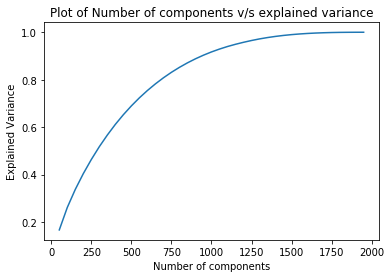

In [21]:
# SVD reduce dimension
# Program to find the optimal number of components for Truncated SVD
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

n_comp = range(50,2000,50) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(ppmi_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f'Number of components = {dim} and explained variance = {variance_sum[-1]}')
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [22]:
# reduce dimension, take dimension=1300

svd = TruncatedSVD(n_components=1300)
ppmi_transformed = svd.fit_transform(ppmi_matrix)

ppmi_transformed.shape


(2000, 1300)

In [27]:
# compute vector which represents document
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: list, word2idx: dict, vocab_list: list):
    
    # vectorizing data 
    # and make document vector by take mean to all word vector
    import numpy as np
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([ppmi_transformed[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
#             print(f"document {i} doesn't contain word in vocab_list")
#             print(corpus[i])
#             print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = tfidf.vocabulary_
vocab_list = tfidf.get_feature_names()

x_train_ppmi, missing_train_list = make_doc_vectors(X_train, word2idx, vocab_list)
print('Number of missing training: ', len(missing_train_list))

x_test_ppmi, missing_test_list = make_doc_vectors(X_test, word2idx, vocab_list)
print('Number of missing testing: ', len(missing_test_list))

Number of missing training:  36
Number of missing testing:  15


In [28]:
# remove missing terms
# y_train
y_train_filter = np.delete(np.array(y_train), missing_train_list)

# knn = KNeighborsClassifier()
# knn.fit(doc_vec_train, y_train_filter)

# y_test
y_test_filter = np.delete(np.array(y_test), missing_test_list)
# train_pred = knn.predict(doc_vec_train)
# test_pred = knn.predict(doc_vec_test)

### 訓練與預測

In [30]:
#build classification model (decision tree, random forest, or adaboost)
#start training
# Decision Tree
def DT(x_train, x_test, y_train, y_test):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20, min_samples_leaf=10)
    dt.fit(x_train, y_train)

    # 計算準確度
    print(f"Accuracy: {dt.score(x_test,y_test)}")

    # 查看決策樹深度與終端節點個數
    print(f"Depth: {dt.get_depth()}, Number of leaves: {dt.get_n_leaves()}")
    
    #calculate confusion matrix, precision, recall, and f1-score
    y_pred = dt.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

print('-'*20, 'Bag of Words', '-'*20)
DT(x_train_cv, x_test_cv, y_train, y_test)

print('-'*20, 'TFIDF', '-'*20)
DT(x_train_tf, x_test_tf, y_train, y_test)

print('-'*20, 'PPMI', '-'*20)
DT(x_train_ppmi, x_test_ppmi, y_train_filter, y_test_filter)


-------------------- Bag of Words --------------------
Accuracy: 0.9044522261130565
Depth: 10, Number of leaves: 59
              precision    recall  f1-score   support

           1       0.66      0.31      0.42       137
           2       0.00      0.00      0.00        76
           3       0.91      0.99      0.95      1786

    accuracy                           0.90      1999
   macro avg       0.52      0.43      0.46      1999
weighted avg       0.86      0.90      0.88      1999

[[  42    0   95]
 [   4    0   72]
 [  18    2 1766]]
-------------------- TFIDF --------------------
Accuracy: 0.9034517258629314
Depth: 10, Number of leaves: 42
              precision    recall  f1-score   support

           1       0.70      0.22      0.33       137
           2       0.00      0.00      0.00        76
           3       0.91      0.99      0.95      1786

    accuracy                           0.90      1999
   macro avg       0.54      0.40      0.43      1999
weighted avg 

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8785282258064516
Depth: 10, Number of leaves: 156
              precision    recall  f1-score   support

           1       0.41      0.29      0.34       137
           2       0.03      0.01      0.02        75
           3       0.92      0.96      0.94      1772

    accuracy                           0.88      1984
   macro avg       0.45      0.42      0.43      1984
weighted avg       0.85      0.88      0.86      1984

[[  40    7   90]
 [   9    1   65]
 [  48   22 1702]]


由上述資訊可以發現, 模型在好評的準確度高(precision, recall都高), 而在差評的部分表現較不理想, 在普通評價的部分大部分跟差評搞混,
同學可以試著學習到的各種方法來提升模型的表現

In [31]:
# Random Forest
def RF(x_train, x_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=10, min_samples_split=20, min_samples_leaf=10)
    rf.fit(x_train, y_train)

    # 計算準確度
    print(f"Accuracy: {rf.score(x_test,y_test)}")
    
    #calculate confusion matrix, precision, recall, and f1-score
    y_pred = rf.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

print('-'*20, 'Bag of Words', '-'*20)
RF(x_train_cv, x_test_cv, y_train, y_test)

print('-'*20, 'TFIDF', '-'*20)
RF(x_train_tf, x_test_tf, y_train, y_test)

print('-'*20, 'PPMI', '-'*20)
RF(x_train_ppmi, x_test_ppmi, y_train_filter, y_test_filter)

-------------------- Bag of Words --------------------
Accuracy: 0.8934467233616809
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       137
           2       0.00      0.00      0.00        76
           3       0.89      1.00      0.94      1786

    accuracy                           0.89      1999
   macro avg       0.30      0.33      0.31      1999
weighted avg       0.80      0.89      0.84      1999

[[   0    0  137]
 [   0    0   76]
 [   0    0 1786]]
-------------------- TFIDF --------------------


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8934467233616809
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       137
           2       0.00      0.00      0.00        76
           3       0.89      1.00      0.94      1786

    accuracy                           0.89      1999
   macro avg       0.30      0.33      0.31      1999
weighted avg       0.80      0.89      0.84      1999

[[   0    0  137]
 [   0    0   76]
 [   0    0 1786]]
-------------------- PPMI --------------------


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8936491935483871
              precision    recall  f1-score   support

           1       1.00      0.01      0.01       137
           2       0.00      0.00      0.00        75
           3       0.89      1.00      0.94      1772

    accuracy                           0.89      1984
   macro avg       0.63      0.34      0.32      1984
weighted avg       0.87      0.89      0.84      1984

[[   1    0  136]
 [   0    0   75]
 [   0    0 1772]]


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Adaboost
def Adaboost(x_train, x_test, y_train, y_test):
    adbt = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                            max_depth=10,
                                                                            min_samples_split=20,
                                                                            min_samples_leaf=10),
                                      n_estimators=50,
                                      learning_rate=0.8)

    #使用adaboost模型進行訓練
    adbt.fit(x_train, y_train)

    # 計算準確度
    print(f"Accuracy: {adbt.score(x_test,y_test)}")
    
    #calculate confusion matrix, precision, recall, and f1-score
    y_pred = adbt.predict(x_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

print('-'*20, 'Bag of Words', '-'*20)
Adaboost(x_train_cv, x_test_cv, y_train, y_test)

print('-'*20, 'TFIDF', '-'*20)
Adaboost(x_train_tf, x_test_tf, y_train, y_test)

print('-'*20, 'PPMI', '-'*20)
Adaboost(x_train_ppmi, x_test_ppmi, y_train_filter, y_test_filter)

-------------------- Bag of Words --------------------
Accuracy: 0.8979489744872436
              precision    recall  f1-score   support

           1       0.60      0.28      0.39       137
           2       0.24      0.07      0.10        76
           3       0.92      0.98      0.95      1786

    accuracy                           0.90      1999
   macro avg       0.58      0.44      0.48      1999
weighted avg       0.87      0.90      0.88      1999

[[  39    2   96]
 [   5    5   66]
 [  21   14 1751]]
-------------------- TFIDF --------------------
Accuracy: 0.8864432216108054
              precision    recall  f1-score   support

           1       0.45      0.18      0.26       137
           2       0.10      0.03      0.04        76
           3       0.91      0.98      0.94      1786

    accuracy                           0.89      1999
   macro avg       0.48      0.40      0.41      1999
weighted avg       0.85      0.89      0.86      1999

[[  25    6  106]
 [  